In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [25]:
filename = 'their-minecraft-state'

outfile_path = os.getcwd() + '/' + filename + '.csv'

df = pd.read_csv(outfile_path)
print(df['Label'].value_counts())
print('df shape: {}'.format(df.shape))
df

2.0    216
0.0    216
1.0    216
Name: Label, dtype: int64
df shape: (648, 989)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,lag1_mean_q1_2,lag1_mean_q1_3,lag1_mean_q2_0,lag1_mean_q2_1,lag1_mean_q2_2,lag1_mean_q2_3,lag1_mean_d_q1q2_0,lag1_mean_d_q1q2_1,lag1_mean_d_q1q2_2,lag1_mean_d_q1q2_3,lag1_mean_d_q1q3_0,lag1_mean_d_q1q3_1,lag1_mean_d_q1q3_2,lag1_mean_d_q1q3_3,lag1_mean_d_q1q4_0,lag1_mean_d_q1q4_1,lag1_mean_d_q1q4_2,lag1_mean_d_q1q4_3,lag1_mean_d_q2q3_0,lag1_mean_d_q2q3_1,lag1_mean_d_q2q3_2,lag1_mean_d_q2q3_3,lag1_mean_d_q2q4_0,lag1_mean_d_q2q4_1,lag1_mean_d_q2q4_2,lag1_mean_d_q2q4_3,lag1_std_0,lag1_std_1,lag1_std_2,lag1_std_3,...,freq_345_3,freq_355_3,freq_365_3,freq_375_3,freq_385_3,freq_395_3,freq_405_3,freq_416_3,freq_426_3,freq_436_3,freq_446_3,freq_456_3,freq_466_3,freq_476_3,freq_486_3,freq_517_3,freq_527_3,freq_537_3,freq_547_3,freq_557_3,freq_568_3,freq_578_3,freq_588_3,freq_598_3,freq_608_3,freq_618_3,freq_628_3,freq_639_3,freq_649_3,freq_659_3,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3,Label
0,-37.277174,-43.030969,-36.447629,-35.684127,-15.007371,-1.645471,1.909458,-10.250657,-30.173763,-39.916087,-39.796470,-33.516623,-29.383747,-44.440061,-35.071250,-27.678812,-0.790017,4.523973,-4.725220,-5.837812,6.458367,5.662108,-5.126744,-2.679067,22.541385,2.258508,-3.502058,17.002314,7.248384,1.138135,-0.401524,3.158745,23.331402,-2.265465,1.223162,22.840125,28.023834,14.467298,12.774093,29.343057,...,0.021732,0.021232,0.025078,0.017825,0.017841,0.013044,0.018389,0.021377,0.016636,0.012611,0.028050,0.020740,0.012425,0.022736,0.006856,0.008109,0.007757,0.008391,0.017940,0.007295,0.029243,0.028707,0.059015,0.085883,0.286109,0.040658,0.036662,0.027230,0.028200,0.007022,0.013639,0.014673,0.016323,0.010981,0.002892,0.007469,0.023877,0.006166,0.010377,1.0
1,-36.642161,-39.056745,-26.281063,-40.255439,-2.241697,-12.631036,-5.477559,12.076263,-47.894014,-25.070973,-27.004605,-61.551798,-23.474208,-40.209633,-20.171075,-31.436875,-24.419806,15.138661,-6.833530,-30.114923,-15.066921,15.271648,-1.551409,-28.668021,-5.324981,25.198574,5.488025,-26.036053,9.352886,0.132987,5.282121,1.446902,19.094825,10.059913,12.321555,4.078870,23.893222,13.968509,8.916534,24.247897,...,0.053020,0.006601,0.035523,0.007717,0.032489,0.012221,0.015919,0.032173,0.001300,0.019843,0.039620,0.026141,0.008231,0.010359,0.015260,0.029119,0.036734,0.029301,0.020995,0.052621,0.044561,0.029328,0.051838,0.249704,0.263516,0.100200,0.059790,0.068045,0.049116,0.014934,0.017032,0.020773,0.008015,0.026345,0.018926,0.030342,0.020967,0.011433,0.032048,0.0
2,-40.229463,-63.108915,-67.984208,-72.194004,-0.341225,6.349947,-4.684524,22.157984,-36.495415,-65.410248,-59.894892,-81.577417,-43.528511,-67.134539,-71.237763,-84.923955,7.033096,1.724291,11.342871,3.346539,-1.740270,-3.825171,8.178684,-20.860880,9.401040,-7.083991,12.625187,-20.074416,-8.773365,-5.549462,-3.164187,-24.207418,2.367944,-8.808282,1.282316,-23.420955,25.958939,10.152055,11.583119,24.049654,...,0.016193,0.031691,0.026972,0.016454,0.018541,0.019849,0.011602,0.015151,0.030528,0.011530,0.004542,0.015281,0.026286,0.021673,0.011241,0.024728,0.018402,0.019532,0.014054,0.020885,0.024565,0.012342,0.007969,0.010732,0.356369,0.009402,0.027355,0.008819,0.016719,0.014779,0.009989,0.024158,0.013508,0.020656,0.015429,0.009691,0.001305,0.013673,0.018705,0.0
3,-37.450039,-39.011419,-35.203550,-37.985609,-0.184593,-2.599875,-2.107257,-4.667253,-39.540556,-38.890191,-35.853357,-38.258455,-35.232372,-36.563790,-32.491314,-33.114101,-4.308184,-2.326401,-3.362043,-5.144354,-2.925313,-0.808662,-0.109735,0.641040,-1.095525,3.592313,0.903864,3.443159,1.382871,1.517739,3.252308,5.785394,3.212659,5.918714,4.265907,8.587513,22.556255,15.329136,14.579360,25.703746,...,0.035406,0.021309,0.048446,0.026083,0.028689,0.011542,0.025038,0.020172,0.027179,0.023257,0.032657,0.016376,0.027345,0.030452,0.012121,0.018237,0.009586,0.032626,0.025033,0.037963

In [26]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = preprocess_inputs(df)

In [27]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)

# consider adding a dense layer after lstm
dense = tf.keras.layers.Dense(16, activation='relu')(gru)

flatten = tf.keras.layers.Flatten()(dense)

outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 988)]             0         
_________________________________________________________________
tf.expand_dims_7 (TFOpLambda (None, 988, 1)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 988, 256)          198912    
_________________________________________________________________
dense_12 (Dense)             (None, 988, 16)           4112      
_________________________________________________________________
flatten_7 (Flatten)          (None, 15808)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 47427     
Total params: 250,451
Trainable params: 250,451
Non-trainable params: 0
_____________________________________________________

In [28]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50
)
model.save(os.getcwd() + '/gdrive/My Drive/gru_dense_50.h5')

Epoch 1/50
15/15 [==============================] - 34s 2s/step - loss: 0.9751 - accuracy: 0.5563 - val_loss: 0.6958 - val_accuracy: 0.6974
Epoch 2/50
15/15 [==============================] - 31s 2s/step - loss: 0.5106 - accuracy: 0.7417 - val_loss: 0.4571 - val_accuracy: 0.7385
Epoch 3/50
15/15 [==============================] - 31s 2s/step - loss: 0.3285 - accuracy: 0.8477 - val_loss: 0.5232 - val_accuracy: 0.7538
Epoch 4/50
15/15 [==============================] - 31s 2s/step - loss: 0.2539 - accuracy: 0.8653 - val_loss: 0.4207 - val_accuracy: 0.7744
Epoch 5/50
15/15 [==============================] - 31s 2s/step - loss: 0.1978 - accuracy: 0.9095 - val_loss: 0.2171 - val_accuracy: 0.9333
Epoch 6/50
15/15 [==============================] - 31s 2s/step - loss: 0.0718 - accuracy: 0.9890 - val_loss: 0.1742 - val_accuracy: 0.9282
Epoch 7/50
15/15 [==============================] - 31s 2s/step - loss: 0.0401 - accuracy: 0.9978 - val_loss: 0.1571 - val_accuracy: 0.9333
Epoch 8/50
15/15 [==

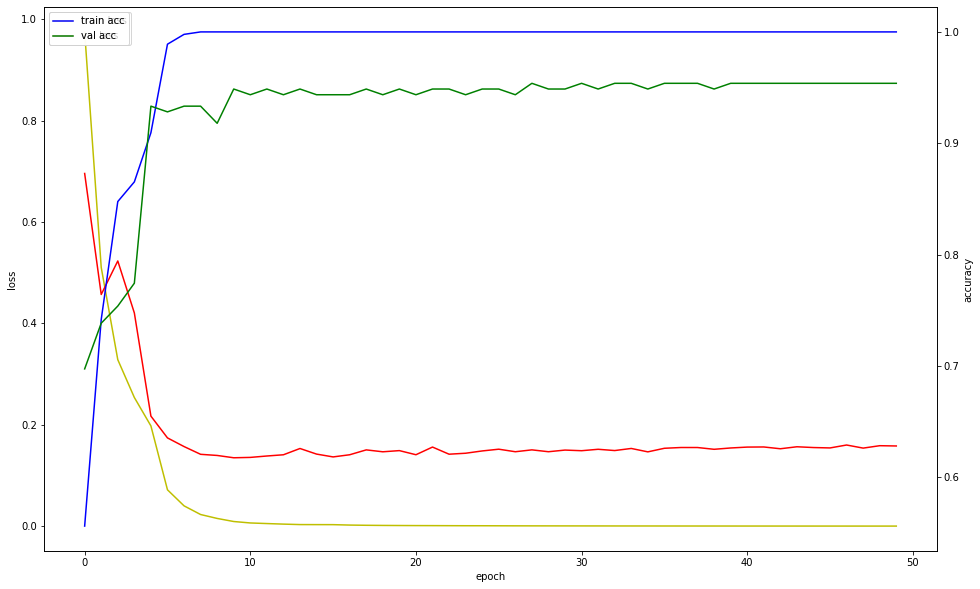

In [29]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

Test Accuracy: 95.385%


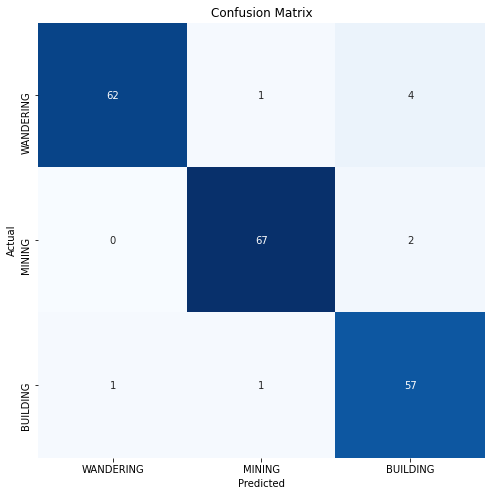

Classification Report:
----------------------
               precision    recall  f1-score   support

   WANDERING       0.98      0.93      0.95        67
      MINING       0.97      0.97      0.97        69
    BUILDING       0.90      0.97      0.93        59

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.96      0.95      0.95       195



In [31]:
model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

label_mapping = {'WANDERING': 0, 'MINING': 1, 'BUILDING': 2}
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_val))))

cm = confusion_matrix(y_val, y_pred)
clr = classification_report(y_val, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)